In [3]:
import pandas as pd
import json 
import codecs 
import networkx as nx 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
from yellowbrick.text import PosTagVisualizer

In [4]:
file ="Data/oz.json"

In [5]:
import itertools 
from nltk import sent_tokenize 

def cooccurrence( text, cast): 
    """ Takes as input text, a dict of chapter {headings: text}, and cast, 
    a comma separated list of character names. Returns a dictionary of 
    cooccurrence counts for each possible pair. """ 
    possible_pairs = list( itertools.combinations( cast, 2)) 
    cooccurring = dict.fromkeys( possible_pairs, 0) 
    for title, chapter in text['chapters']. items(): 
        for sent in sent_tokenize(chapter): 
            for pair in possible_pairs: 
                if pair[ 0] in sent and pair[ 1] in sent:
                    cooccurring[ pair] += 1 
    return cooccurring



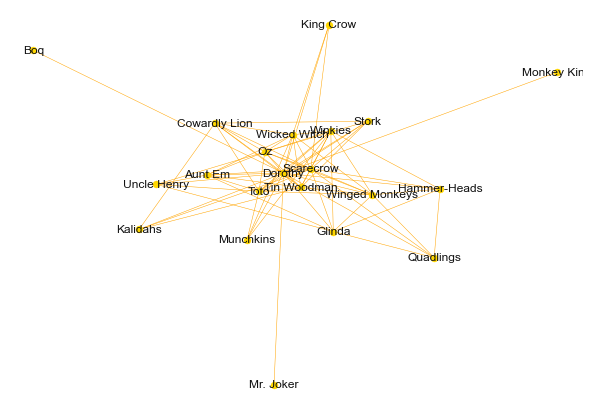

In [6]:
with codecs.open(file, 'r', 'utf-8-sig') as data: 
    text = json.load(data) 
    cast = text['cast'] 
    G = nx.Graph() 
    G.name = "The Social Network of Oz" 
    pairs = cooccurrence( text, cast) 
    for pair, wgt in pairs.items(): 
        if wgt > 0: 
            G.add_edge(pair[ 0], pair[ 1], weight = wgt) 
            # Make Dorothy the center 
    D = nx.ego_graph( G, "Dorothy") 
    edges, weights = zip(* nx.get_edge_attributes( D, "weight"). items()) 
    # Push nodes away that are less related to Dorothy 
    pos = nx.spring_layout( D, k =.5, iterations = 40) 
    nx.draw( D, pos, node_color ="gold", node_size = 50, edgelist = edges, width =.5, edge_color ="orange", with_labels = True, font_size = 12) 
    plt.show()



#### Co-occurrence plots 

Co-occurrence is another way to quickly understand relationships between entities or other n-grams, in terms of the frequency with which they appear together. In this section we’ll use Matplotlib to plot character co-occurrences in The Wizard of Oz. First, we create a function matrix that will take in the text of the book and the list of characters. We initialize a multidimensional array that will be a list that contains a list for every character with the count of its co-occurrences with every other character:

In [7]:
from nltk import sent_tokenize 

def matrix( text, cast): 
    mtx = [] 
    for first in cast: 
        row = [] 
        for second in cast: 
            count = 0 
            for title, chapter in text['chapters']. items(): 
                for sent in sent_tokenize( chapter): 
                    if first in sent and second in sent: 
                        count += 1 
            row.append( count) 
        mtx.append( row) 
    return mtx 


In [11]:
with codecs.open(file, 'r', 'utf-8-sig') as data: 
    text = json.load(data) 
    cast = text['cast'] 
    #print(cast)
    print(text)

{'cast': ['Dorothy', 'Scarecrow', 'Oz', 'Tin Woodman', 'Toto', 'Wicked Witch', 'Winkies', 'Winged Monkeys', 'Aunt Em', 'Cowardly Lion', 'Munchkins', 'Glinda', 'Uncle Henry', 'Stork', 'Quelala', 'Kalidahs', 'Quadlings', 'Gayelette', 'Boq', 'Monkey King', 'Hammer-Heads', 'King Crow', 'Mr. Joker', 'china Princess', 'Green Girl'], 'chapters': {'1.The Cyclone': "Dorothy lived in the midst of the great Kansas prairies, with Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's wife. Their house was small, for the lumber to build it had to be carried by wagon many miles. There were four walls, a floor and a roof, which made one room; and this room contained a rusty looking cookstove, a cupboard for the dishes, a table, three or four chairs, and the beds. Uncle Henry and Aunt Em had a big bed in one corner, and Dorothy a little bed in another corner. There was no garret at all, and no cellar--except a small hole dug in the ground, called a cyclone cellar, where the family could go i

In [ ]:
mtx = matrix(text,cast)


In [ ]:
mtx.shape

In [ ]:
len(mtx)

In [69]:
len(mtx)

25

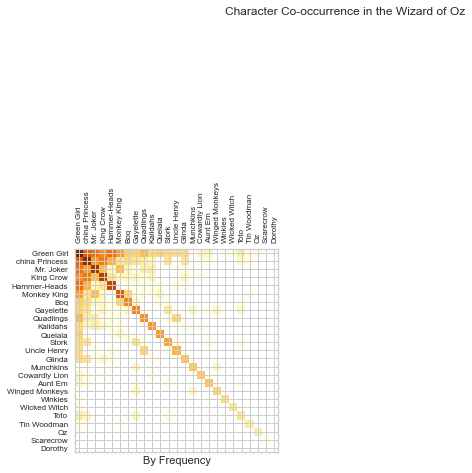

In [144]:
#import matplotlib as mpl 
#matplotlib.rcParams["figure.figsize"] = (10,10)

# Now create the plots 
fig, ax = plt.subplots() 
fig.suptitle('Character Co-occurrence in the Wizard of Oz', fontsize = 12) 
fig.subplots_adjust(wspace =.75)
n = len(cast) 
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n) 
ax1 = plt.subplot(121) 
ax1.set_xticks(x_tick_marks) 
ax1.set_yticks(y_tick_marks) 
ax1.set_xticklabels(cast, fontsize = 8, rotation = 90) 
ax1.set_yticklabels(cast, fontsize = 8) 
ax1.xaxis.tick_top() 
ax1.set_xlabel("By Frequency") 
plt.imshow( mtx, norm = matplotlib.colors.LogNorm(), interpolation ='nearest', cmap ='YlOrBr')


In [79]:
# And alphabetically 
alpha_cast = sorted(cast) 
alpha_mtx = matrix(text, alpha_cast) 


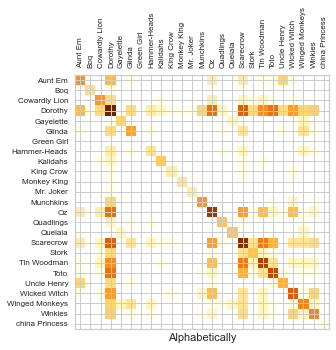

In [145]:
ax2 = plt.subplot(122) 

ax2.set_xticks(x_tick_marks) 
ax2.set_yticks(y_tick_marks) 
ax2.set_xticklabels(alpha_cast, fontsize = 8, rotation = 90) 
ax2.set_yticklabels(alpha_cast, fontsize = 8) 
ax2.xaxis.tick_top() 
ax2.set_xlabel("Alphabetically") 
plt.imshow( alpha_mtx, norm = matplotlib.colors.LogNorm(), interpolation ='nearest', cmap ='YlOrBr') 
plt.show()


#### Text x-rays and dispersion plots 

While the network and co-occurrence plots do begin to elucidate the relationships between entities in a text (or characters in a plot), as well as which entities play some of the most important roles, they do not reflect very much about their various roles in the narrative. For this, we require something akin to Jeff Clark3 and Trevor Stephen’s4 dispersion plots. A dispersion plot provides a kind of “x-ray” of the text, plotting each character name along the y-axis and having the narrative plotted along the x-axis, such that a horizontal line can be added next to each character at the points in which he or she appears in the plot. We can recreate a dispersion plot in Matplotlib using our Wizard of Oz text as follows. First, we need a list of oz_words of every word in the text in the order it occurs. We will also keep track of the lengths and headings of each chapter, so that we can later plot these along the x-axis to show where chapters begin and end:

In [87]:
from nltk import word_tokenize, sent_tokenize 
# Plot mentions of characters through chapters 
oz_words = [] 
headings = [] 
chap_lens = [] 
for heading, chapter in text['chapters']. items(): 
    # Collect the chapter headings 
    headings.append(heading) 
    for sent in sent_tokenize(chapter): 
        for word in word_tokenize(sent): 
            # Collect all of the words 
            oz_words.append(word) 
    # Record the word lengths at each chapter 
    chap_lens.append( len(oz_words)) 
    # Mark where chapters start 
    chap_starts = [0] + chap_lens[:-1] 
    # Combine with chapter headings 
    chap_marks = list(zip(chap_starts, headings))


Now we want to search through the list of oz_words to look for places where the characters appear, adding these to a list of points for plotting. In our case, some of our characters have one-word names (e.g., “Dorothy,” “Scarecrow,” “Glinda”), while others have two-word names (“ Cowardly Lion,” “Monkey King”). To ensure we match types of strings, we’ll first catalog the one-word name matches, checking for each word in the text to see if it matches a name, and then we’ll look for the two-name characters by looking at each word together with its preceding word:

In [90]:
cast.reverse() 
points = [] 
# Add a point for each time a character appears 
for y in range( len(cast)): 
    for x in range( len(oz_words)): 
        # Some characters have 1-word names
        if len( cast[ y]. split()) == 1: 
            if cast[ y] == oz_words[x]: 
                points.append((x, y)) 
            # Some characters have 2-word names 
        else: 
            if cast[ y] == ' '. join((oz_words[ x-1], oz_words[ x])): 
                points.append((x, y)) 
if points: 
    x, y = list( zip(*points)) 
else: x = y = ()


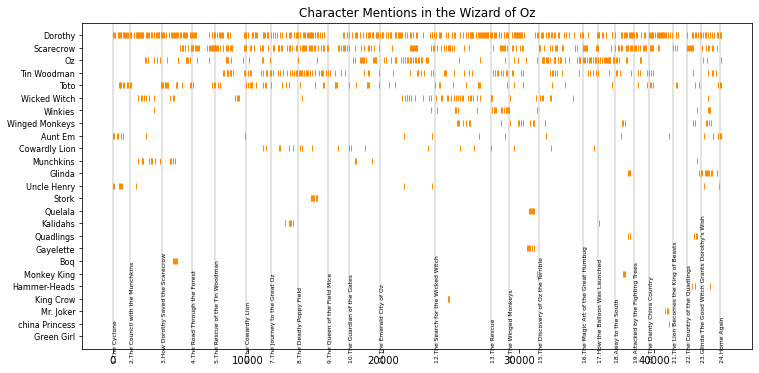

In [108]:
# Create the plot 
fig, ax = plt.subplots(figsize =(12,6)) 
# Add vertical lines labeled for each chapter start 

for chap in chap_marks: 
    plt.axvline(x = chap[ 0], linestyle ='-', color ='gainsboro') 
    plt.text(chap[0], -2, chap[1], size = 6, rotation = 90) 
# Plot the character mentions 
plt.plot(x, y, "|", color ="darkorange", scalex =.1) 
plt.tick_params(axis ='x', which ='both', bottom ='off', labelbottom ='off') 
plt.yticks(list(range( len(cast))), cast, size = 8) 
plt.ylim(-1, len(cast)) 
plt.title("Character Mentions in the Wizard of Oz")
plt.show()


In [112]:
from nltk import pos_tag, word_tokenize 
from yellowbrick.text.postag import PosTagVisualizer 


In [128]:
pie = """ 
    In a small saucepan, combine sugar and eggs until well blended. 
    Cook over low heat, stirring constantly, until mixture reaches 160° 
    and coats the back of a metal spoon. Remove from the heat. Stir in 
    chocolate and vanilla until smooth. Cool to lukewarm (90 °), 
    stirring occasionally. In a small bowl, cream butter until light 
    and fluffy. Add cooled chocolate mixture; beat on high speed for
    5 minutes or until light and fluffy. In another large bowl, beat
    cream until it begins to thicken. Add confectioners' sugar; beat 
    until stiff peaks form. Fold into chocolate mixture. Pour into crust. 
    Chill for at least 6 hours before serving. Garnish with whipped cream 
    and chocolate curls if desired. """ 

tokens = word_tokenize(pie) 
#print(tokens)
tagged = pos_tag(tokens)
print(tagged)


[('In', 'IN'), ('a', 'DT'), ('small', 'JJ'), ('saucepan', 'NN'), (',', ','), ('combine', 'NN'), ('sugar', 'NN'), ('and', 'CC'), ('eggs', 'NNS'), ('until', 'IN'), ('well', 'RB'), ('blended', 'VBN'), ('.', '.'), ('Cook', 'NNP'), ('over', 'IN'), ('low', 'JJ'), ('heat', 'NN'), (',', ','), ('stirring', 'VBG'), ('constantly', 'RB'), (',', ','), ('until', 'IN'), ('mixture', 'NN'), ('reaches', 'VBZ'), ('160°', 'CD'), ('and', 'CC'), ('coats', 'VB'), ('the', 'DT'), ('back', 'NN'), ('of', 'IN'), ('a', 'DT'), ('metal', 'NN'), ('spoon', 'NN'), ('.', '.'), ('Remove', 'VB'), ('from', 'IN'), ('the', 'DT'), ('heat', 'NN'), ('.', '.'), ('Stir', 'NNP'), ('in', 'IN'), ('chocolate', 'NN'), ('and', 'CC'), ('vanilla', 'NN'), ('until', 'IN'), ('smooth', 'JJ'), ('.', '.'), ('Cool', 'NNP'), ('to', 'TO'), ('lukewarm', 'VB'), ('(', '('), ('90', 'CD'), ('°', 'NN'), (')', ')'), (',', ','), ('stirring', 'VBG'), ('occasionally', 'RB'), ('.', '.'), ('In', 'IN'), ('a', 'DT'), ('small', 'JJ'), ('bowl', 'NN'), (',', ',')

In [129]:
visualizer = PosTagVisualizer() 
visualizer.transform(tagged) 
print(' '. join(( visualizer.colorize( token, color) for color, token in visualizer.tagset))) 
print('\ n')


ValueError: not enough values to unpack (expected 2, got 1)

In [124]:
# Create the visualizer, fit, score, and show it
viz = PosTagVisualizer()
viz.fit(tagged)
viz.show()

ValueError: not enough values to unpack (expected 2, got 1)

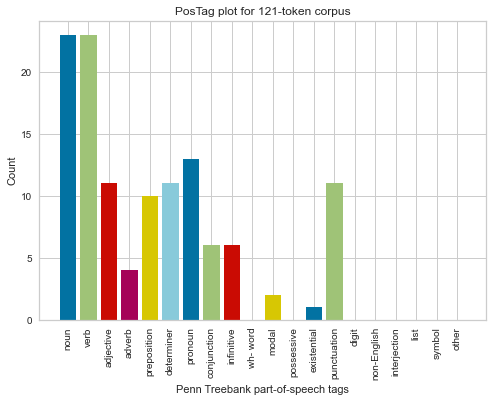

In [114]:
from yellowbrick.text import PosTagVisualizer


tagged_stanzas = [
    [
        [
            ('Whose', 'JJ'),('woods', 'NNS'),('these', 'DT'),
            ('are', 'VBP'),('I', 'PRP'),('think', 'VBP'),('I', 'PRP'),
            ('know', 'VBP'),('.', '.')
            ],
        [
            ('His', 'PRP$'),('house', 'NN'),('is', 'VBZ'),('in', 'IN'),
            ('the', 'DT'),('village', 'NN'),('though', 'IN'),(';', ':'),
            ('He', 'PRP'),('will', 'MD'),('not', 'RB'),('see', 'VB'),
            ('me', 'PRP'),('stopping', 'VBG'), ('here', 'RB'),('To', 'TO'),
            ('watch', 'VB'),('his', 'PRP$'),('woods', 'NNS'),('fill', 'VB'),
            ('up', 'RP'),('with', 'IN'),('snow', 'NNS'),('.', '.')
            ]
        ],
    [
        [
            ('My', 'PRP$'),('little', 'JJ'),('horse', 'NN'),('must', 'MD'),
            ('think', 'VB'),('it', 'PRP'),('queer', 'JJR'),('To', 'TO'),
            ('stop', 'VB'),('without', 'IN'),('a', 'DT'),('farmhouse', 'NN'),
            ('near', 'IN'),('Between', 'NNP'),('the', 'DT'),('woods', 'NNS'),
            ('and', 'CC'),('frozen', 'JJ'),('lake', 'VB'),('The', 'DT'),
            ('darkest', 'JJS'),('evening', 'NN'),('of', 'IN'),('the', 'DT'),
            ('year', 'NN'),('.', '.')
            ]
        ],
    [
        [
            ('He', 'PRP'),('gives', 'VBZ'),('his', 'PRP$'),('harness', 'NN'),
            ('bells', 'VBZ'),('a', 'DT'),('shake', 'NN'),('To', 'TO'),
            ('ask', 'VB'),('if', 'IN'),('there', 'EX'),('is', 'VBZ'),
            ('some', 'DT'),('mistake', 'NN'),('.', '.')
            ],
        [
            ('The', 'DT'),('only', 'JJ'),('other', 'JJ'),('sound', 'NN'),
            ('’', 'NNP'),('s', 'VBZ'),('the', 'DT'),('sweep', 'NN'),
            ('Of', 'IN'),('easy', 'JJ'),('wind', 'NN'),('and', 'CC'),
            ('downy', 'JJ'),('flake', 'NN'),('.', '.')
            ]
        ],
    [
        [
            ('The', 'DT'),('woods', 'NNS'),('are', 'VBP'),('lovely', 'RB'),
            (',', ','),('dark', 'JJ'),('and', 'CC'),('deep', 'JJ'),(',', ','),
            ('But', 'CC'),('I', 'PRP'),('have', 'VBP'),('promises', 'NNS'),
            ('to', 'TO'),('keep', 'VB'),(',', ','),('And', 'CC'),('miles', 'NNS'),
            ('to', 'TO'),('go', 'VB'),('before', 'IN'),('I', 'PRP'),
            ('sleep', 'VBP'),(',', ','),('And', 'CC'),('miles', 'NNS'),
            ('to', 'TO'),('go', 'VB'),('before', 'IN'),('I', 'PRP'),
            ('sleep', 'VBP'),('.', '.')
            ]
    ]
]

# Create the visualizer, fit, score, and show it
viz = PosTagVisualizer()
viz.fit(tagged_stanzas)
viz.show()

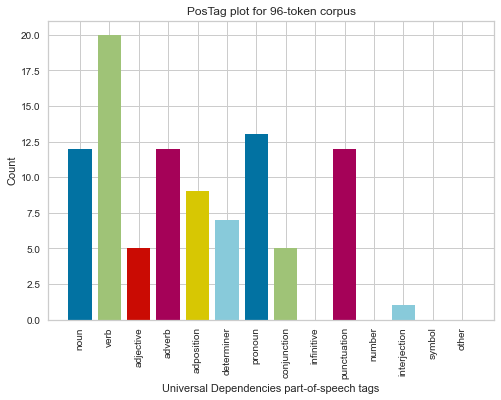

In [120]:
from yellowbrick.text import PosTagVisualizer

tagged_speech = [
    [
        [
            ('In', 'ADP'),('all', 'DET'),('honesty', 'NOUN'),(',', 'PUNCT'),
            ('I', 'PRON'),('said', 'VERB'),('yes', 'INTJ'),('to', 'ADP'),
            ('the', 'DET'),('fear', 'NOUN'),('of', 'ADP'),('being', 'VERB'),
            ('on', 'ADP'),('this', 'DET'),('stage', 'NOUN'),('tonight', 'NOUN'),
            ('because', 'ADP'),('I', 'PRON'),('wanted', 'VERB'),('to', 'PART'),
            ('be', 'VERB'),('here', 'ADV'),(',', 'PUNCT'),('to', 'PART'),
            ('look', 'VERB'),('out', 'PART'),('into', 'ADP'),('this', 'DET'),
            ('audience', 'NOUN'),(',', 'PUNCT'),('and', 'CCONJ'),
            ('witness', 'VERB'),('this', 'DET'),('moment', 'NOUN'),('of', 'ADP'),
            ('change', 'NOUN')
            ],
        [
            ('and', 'CCONJ'),('I', 'PRON'),("'m", 'VERB'),('not', 'ADV'),
            ('fooling', 'VERB'),('myself', 'PRON'),('.', 'PUNCT')
            ],
        [
            ('I', 'PRON'),("'m", 'VERB'),('not', 'ADV'),('fooling', 'VERB'),
            ('myself', 'PRON'),('.', 'PUNCT')
            ],
        [
            ('Next', 'ADJ'),('year', 'NOUN'),('could', 'VERB'),('be', 'VERB'),
            ('different', 'ADJ'),('.', 'PUNCT')
            ],
        [
            ('It', 'PRON'),('probably', 'ADV'),('will', 'VERB'),('be', 'VERB'),
            (',', 'PUNCT'),('but', 'CCONJ'),('right', 'ADV'),('now', 'ADV'),
            ('this', 'DET'),('moment', 'NOUN'),('is', 'VERB'),('real', 'ADJ'),
            ('.', 'PUNCT')
            ],
        [
            ('Trust', 'VERB'),('me', 'PRON'),(',', 'PUNCT'),('it', 'PRON'),
            ('is', 'VERB'),('real', 'ADJ'),('because', 'ADP'),('I', 'PRON'),
            ('see', 'VERB'),('you', 'PRON')
            ],
        [
            ('and', 'CCONJ'), ('I', 'PRON'), ('see', 'VERB'), ('you', 'PRON')
            ],
        [
            ('—', 'PUNCT')
            ],
        [
            ('all', 'ADJ'),('these', 'DET'),('faces', 'NOUN'),('of', 'ADP'),
            ('change', 'NOUN')
            ],
        [
            ('—', 'PUNCT'),('and', 'CCONJ'),('now', 'ADV'),('so', 'ADV'),
            ('will', 'VERB'),('everyone', 'NOUN'),('else', 'ADV'), ('.', 'PUNCT')
            ]
    ]
]

# Create the visualizer, fit, score, and show it
viz = PosTagVisualizer(tagset="universal")
viz.fit(tagged_speech)
viz.show()

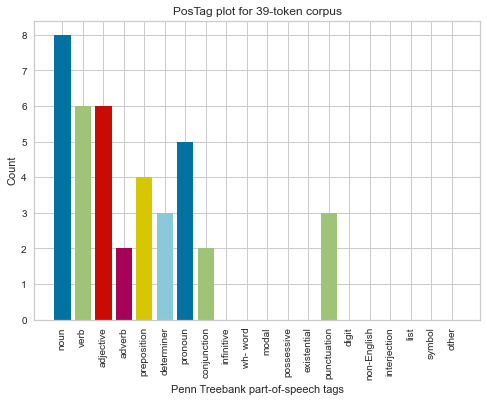

<Figure size 576x396 with 0 Axes>

In [121]:
from yellowbrick.text.postag import postag

machado = [
    [
        [
            ('Last', 'JJ'), ('night', 'NN'), ('as', 'IN'), ('I', 'PRP'),
            ('was', 'VBD'), ('sleeping', 'VBG'), (',', ','), ('I', 'PRP'),
            ('dreamt', 'VBP'), ('—', 'RB'), ('marvelous', 'JJ'), ('error', 'NN'),
            ('!—', 'IN'), ('that', 'DT'), ('I', 'PRP'), ('had', 'VBD'), ('a', 'DT'),
            ('beehive', 'NN'), ('here', 'RB'), ('inside', 'IN'), ('my', 'PRP$'),
            ('heart', 'NN'), ('.', '.')
            ],
        [
            ('And', 'CC'), ('the', 'DT'), ('golden', 'JJ'), ('bees', 'NNS'),
            ('were', 'VBD'), ('making', 'VBG'), ('white', 'JJ'), ('combs', 'NNS'),
            ('and', 'CC'), ('sweet', 'JJ'), ('honey', 'NN'), ('from', 'IN'),
            ('my', 'PRP$'), ('old', 'JJ'), ('failures', 'NNS'), ('.', '.')
            ]
    ]
]

# Create the visualizer, fit, score, and show it
postag(machado)
plt.tight_layout()

In [126]:
untagged_speech = u'Whose woods these are I think I know'

# Create the visualizer, fit, score, and show it
viz = PosTagVisualizer(parser='nltk_word')
viz.fit(untagged_speech)
viz.show()

LookupError: Error occured because nltk postag data is not available

In [130]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(
    features=features, algorithm='covariance'
)
visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.show()     

NameError: name 'features' is not defined

In [131]:
from sklearn.svm import LinearSVC
from yellowbrick.classifier import ROCAUC

model = LinearSVC()
model.fit(X,y)
visualizer = ROCAUC(model)
visualizer.score(X,y)
visualizer.show()


NameError: name 'X' is not defined